### Explainable AI (XAI) by SHapley Additive exPlanations (SHAP)
- This note aims to understand a model by SHAP method.
- Electricity prices (day-ahead prices) is predicted by random forest model using data which consists of load(amount of demond for electricity), amount of electricity from different type of power plants, and time(0-23 hours).
- SHAP values can explain which features are most impact on the model.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import shap
shap.initjs()

In [2]:
# Imports data
df = pd.read_csv('Dataset.csv')
print('Dataset size:', df.shape)

Dataset size: (42719, 17)


In [3]:
df.head()

,Unnamed: 0,Date_CET,Day-ahead[Euro/MWh],Load[MWh],Gas[MWh],Lignite[MWh],Coal[MWh],Nuclear[MWh],Other_conventional[MWh],Hydro_pumped_storage[MWh],Hydropower[MWh],Biomass[MWh],PV[MWh],Wind_onshore[MWh],Wind_offshore[MWh],Other_renewable[MWh],Time
0,0,2015-01-01 00:00:00+01:00,25.02,42097.00,1007.0,15737.0,2771.0,10711.0,4905.00,1336.0,1162.0,4024.0,0.0,8129.0,517.0,132.0,0
1,1,2015-01-01 01:00:00+01:00,18.29,40665.25,499.0,15367.0,1918.0,11088.0,5034.25,851.0,1193.0,3982.0,0.0,8300.0,516.0,122.0,1
2,2,2015-01-01 02:00:00+01:00,16.04,39510.00,403.0,14855.0,1811.0,11027.0,5113.75,599.0,1143.0,4018.0,0.0,8544.0,514.0,93.0,2
3,3,2015-01-01 03:00:00+01:00,14.60,38536.75,404.0,14113.0,1945.0,11030.0,5085.25,119.0,1126.0,4040.0,0.0,8552.0,519.0,86.0,3
4,4,2015-01-01 04:00:00+01:00,14.95,38153.00,405.0,14149.0,1999.0,10964.0,5106.00,223.0,1118.0,4037.0,0.0,8646.0,522.0,84.0,4


In [4]:
df.dtypes

Unnamed: 0                     int64
Date_CET                      object
Day-ahead[Euro/MWh]          float64
Load[MWh]                    float64
Gas[MWh]                     float64
Lignite[MWh]                 float64
Coal[MWh]                    float64
Nuclear[MWh]                 float64
Other_conventional[MWh]      float64
Hydro_pumped_storage[MWh]    float64
Hydropower[MWh]              float64
Biomass[MWh]                 float64
PV[MWh]                      float64
Wind_onshore[MWh]            float64
Wind_offshore[MWh]           float64
Other_renewable[MWh]         float64
Time                           int64
dtype: object

In [5]:
# Count NaN in each column
df.isna().sum()

Unnamed: 0                   0
Date_CET                     0
Day-ahead[Euro/MWh]          0
Load[MWh]                    0
Gas[MWh]                     0
Lignite[MWh]                 0
Coal[MWh]                    0
Nuclear[MWh]                 0
Other_conventional[MWh]      0
Hydro_pumped_storage[MWh]    0
Hydropower[MWh]              0
Biomass[MWh]                 0
PV[MWh]                      0
Wind_onshore[MWh]            0
Wind_offshore[MWh]           0
Other_renewable[MWh]         0
Time                         0
dtype: int64

In [6]:
# Drop unnecessary column
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [7]:
# Split into training set and test set (40% of data is for test set because calculation of shap values is expensive)
train, test = train_test_split(df, test_size = 0.4, random_state = 0)
print('Train set size:', train.shape, '\nTest set size:', test.shape)

Train set size: (25631, 16) 
Test set size: (17088, 16)


In [8]:
# Create a list for independent variables
list_variable = list(train)
list_variable.remove('Date_CET')
list_variable.remove('Day-ahead[Euro/MWh]')

In [9]:
# Create train sets and test sets
x_train = train[list_variable]
y_train = train['Day-ahead[Euro/MWh]']
x_test = test[list_variable]
y_test = test['Day-ahead[Euro/MWh]']

print('Train set size for independent variables:', x_train.shape)
print('Train set size for a dependent variable:', y_train.shape)
print('Test set size for independent variables:', x_test.shape)
print('Test set size for a dependent variable:', y_test.shape)

Train set size for independent variables: (25631, 14)
Train set size for a dependent variable: (25631,)
Test set size for independent variables: (17088, 14)
Test set size for a dependent variable: (17088,)


In [10]:
# Use random forest model, fit the model, predict a target variable, and evaluate the model based on RMSE and adjusted R^2 
model = RandomForestRegressor(n_estimators = 5, random_state = 0)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

rmse_score_result = np.sqrt(mean_squared_error(y_test, y_pred))
r2_score_result = r2_score(y_test, y_pred)
adjusted_r2_score_result = 1 - (1-r2_score_result)*(len(y_test)-1)/(len(y_test)-x_train.shape[1]-1)
print('RMSE:',round(rmse_score_result,3),'\nAdj_R^2:',round(adjusted_r2_score_result,3))

RMSE: 5.306 
Adj_R^2: 0.89


In [11]:
# Use 'TreeExplainer' because the model is random forest
explainer = shap.TreeExplainer(model, x_train)

In [12]:
# Calculate SHAP values using training set 
shap_values = explainer.shap_values(x_train)

100%|===================| 25590/25631 [02:15<00:00]        

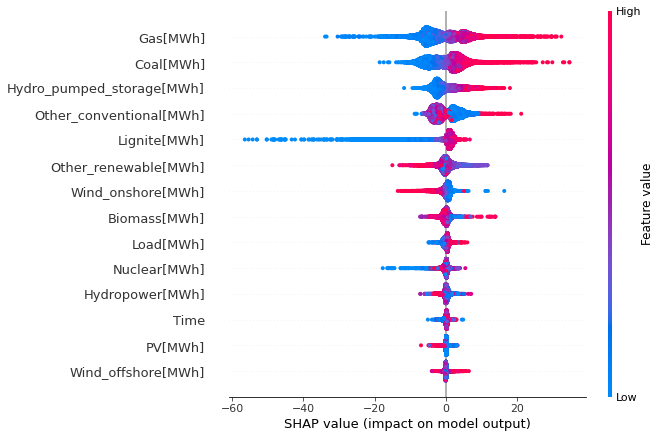

In [13]:
# Plot the SHAP values
shap.summary_plot(shap_values, x_train)

#### The above figure explains:
- High gas values (red color) are a high positive impact on this model output. -> Electricity prices are expensive.
- Low lignite values (blue color) are a high negative impact on this model output. -> Electricity prices are cheap.
- Low wind_onshore values (blue color) are a positive impact on this model output. -> Electricity prices are expensive.  
  ...and so on.

#### SHAP values are easy to understand which features have a positive/negative impact on the model.